# OpenET Model Runtime Comparison
## Single Landsat Image Benchmark

This notebook benchmarks the wallclock runtime for computing ET across
RADET and four other OpenET models: SIMS, SSEBop, geeSEBAL, and DisALEXI.

Each model's `.et` property is evaluated via `reduceRegion().getInfo()` over the full scene
geometry. Benchmarks are run across 10 distinct Landsat scenes to capture variability.

Note that due to in-built GEE caching, running the same cell using the same Landsat scenes repeatedly will result in 
different run times, with the latter ones being much faster. Although we add random noise, it does not fully avoid
caching.

## Setup

In [ ]:
%pip install earthengine-api openet-core pandas seaborn openet-sims openet-ptjpl openet-ssebop openet-disalexi openet-geesebal

In [1]:
import ee
import time
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get the notebook's directory and derive repo root
NOTEBOOK_DIR = Path(globals()['__vsc_ipynb_file__']).resolve().parent
REPO_ROOT = NOTEBOOK_DIR.parent
os.chdir(REPO_ROOT)
OUTPUT_DIR = NOTEBOOK_DIR / 'eecu_output'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


import radet
import openet.disalexi
import openet.geesebal
import openet.ptjpl
import openet.ssebop
import openet.sims

### Initialize Earth Engine

In [2]:
try:
    ee.Initialize()
except ee.EEException:
    ee.Authenticate()
    ee.Initialize()

## Define Input Scenes

In [3]:
# 10 Landsat 8 Collection 2 SR scenes across interior CONUS (for 5 km buffer benchmarks)
SCENE_IDS = [
    'LANDSAT/LC08/C02/T1_L2/LC08_043031_20240829',  # CA, NV, OR (Great Basin)
    'LANDSAT/LC08/C02/T1_L2/LC08_035033_20240821',  # CO
    'LANDSAT/LC08/C02/T1_L2/LC08_028032_20240820',  # NE/KS (Great Plains)
    'LANDSAT/LC08/C02/T1_L2/LC08_023035_20240817',  # AR/MS (Lower Mississippi)
    'LANDSAT/LC08/C02/T1_L2/LC08_018033_20240830',  # VA/WV (Appalachia)
    'LANDSAT/LC08/C02/T1_L2/LC08_021031_20240819',  # IN/MI (Midwest)
    'LANDSAT/LC08/C02/T1_L2/LC08_034030_20240830',  # WY
    'LANDSAT/LC08/C02/T1_L2/LC08_039031_20240817',  # NV/UT/ID (Great Basin)
    'LANDSAT/LC08/C02/T1_L2/LC08_026034_20240822',  # MO/AR (Ozarks)
    'LANDSAT/LC08/C02/T1_L2/LC08_045030_20240827',  # OR (Willamette Valley)
]

print(f'{len(SCENE_IDS)} scenes selected')

10 scenes selected


In [5]:
# Validate that all scenes exist in GEE
for sid in SCENE_IDS:
    try:
        info = ee.Image(sid).getInfo()
        status = 'OK' if info else 'NOT FOUND'
    except Exception as e:
        status = f'ERROR: {e}'
    print(f'{status:10s}  {sid.split("/")[-1]}')

OK          LC08_043031_20240829
OK          LC08_035033_20240821
OK          LC08_028032_20240820
OK          LC08_023035_20240817
OK          LC08_018033_20240830
OK          LC08_021031_20240819
OK          LC08_034030_20240830
OK          LC08_039031_20240817
OK          LC08_026034_20240822
OK          LC08_045030_20240827


## Benchmark Function

In [6]:
def benchmark_model(model_factory, scene_ids=SCENE_IDS):
    """Benchmark a model across multiple Landsat scenes.
    
    Parameters
    ----------
    model_factory : callable
        Function that takes an ee.Image and returns the ET ee.Image.
    scene_ids : list of str
        Landsat image IDs to benchmark.
    
    Returns
    -------
    list of float
        Wallclock seconds for each scene.
    """
    times = []
    n = len(scene_ids)
    for i, sid in enumerate(scene_ids):
        img = ee.Image(sid)
        region = img.geometry().centroid().buffer(5000) # 5 km buffer around centroid to avoid GEE memory issues
        et_image = model_factory(img)
        # Add a unique server-side random noise band to defeat GEE caching.
        # ee.Image.random() with a unique seed produces a distinct computation
        # graph each time, and multiplying by 1e-10 makes it negligible.
        noise = ee.Image.random(i * n + hash(sid)).multiply(1e-10)
        et_image = et_image.add(noise)
        start = time.time()
        et_image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=30,
            bestEffort=True,
        ).getInfo()
        elapsed = time.time() - start
        times.append(elapsed)
        scene_short = sid.split('/')[-1]
        print(f'  Scene {i + 1}/{n} ({scene_short}): {elapsed:.2f}s')
    return times

## Instantiate Models and Run Benchmarks

In [7]:
results_5k = {}

# Common kwargs for models that need ET reference
et_ref_kwargs = dict(
    et_reference_source='IDAHO_EPSCOR/GRIDMET',
    et_reference_band='etr',
    et_reference_resample='bilinear',
)

### RADET

In [234]:
print('Benchmarking RADET...')
def radet_factory(img):
    return radet.Image.from_landsat_c2_sr(
        img, meteorology_source_daily='IDAHO_EPSCOR/GRIDMET', **et_ref_kwargs,
    ).et
results_5k['RADET'] = benchmark_model(radet_factory)

Benchmarking RADET...
  Scene 1/10 (LC08_043031_20240829): 3.79s
  Scene 2/10 (LC08_035033_20240821): 8.39s
  Scene 3/10 (LC08_028032_20240820): 2.79s
  Scene 4/10 (LC08_023035_20240817): 2.66s
  Scene 5/10 (LC08_018033_20240830): 3.01s
  Scene 6/10 (LC08_021031_20240819): 2.20s
  Scene 7/10 (LC08_034030_20240830): 3.17s
  Scene 8/10 (LC08_039031_20240817): 2.94s
  Scene 9/10 (LC08_026034_20240822): 1.38s
  Scene 10/10 (LC08_045030_20240827): 1.92s


### PT-JPL

In [235]:
print('Benchmarking PT-JPL...')
def ptjpl_factory(img):
    return openet.ptjpl.Image.from_landsat_c2_sr(img).et
results_5k['PT-JPL'] = benchmark_model(ptjpl_factory)

Benchmarking PT-JPL...
  Scene 1/10 (LC08_043031_20240829): 1.32s
  Scene 2/10 (LC08_035033_20240821): 6.04s
  Scene 3/10 (LC08_028032_20240820): 0.92s
  Scene 4/10 (LC08_023035_20240817): 1.78s
  Scene 5/10 (LC08_018033_20240830): 1.36s
  Scene 6/10 (LC08_021031_20240819): 0.99s
  Scene 7/10 (LC08_034030_20240830): 1.56s
  Scene 8/10 (LC08_039031_20240817): 0.86s
  Scene 9/10 (LC08_026034_20240822): 0.51s
  Scene 10/10 (LC08_045030_20240827): 1.17s


### SIMS

In [236]:
print('Benchmarking SIMS...')
def sims_factory(img):
    return openet.sims.Image.from_landsat_c2_sr(img, **et_ref_kwargs).et
results_5k['SIMS'] = benchmark_model(sims_factory)

Benchmarking SIMS...
  Scene 1/10 (LC08_043031_20240829): 1.17s
  Scene 2/10 (LC08_035033_20240821): 0.77s
  Scene 3/10 (LC08_028032_20240820): 0.44s
  Scene 4/10 (LC08_023035_20240817): 0.96s
  Scene 5/10 (LC08_018033_20240830): 0.66s
  Scene 6/10 (LC08_021031_20240819): 0.80s
  Scene 7/10 (LC08_034030_20240830): 0.89s
  Scene 8/10 (LC08_039031_20240817): 0.73s
  Scene 9/10 (LC08_026034_20240822): 0.96s
  Scene 10/10 (LC08_045030_20240827): 1.81s


### SSEBop

In [237]:
print('Benchmarking SSEBop...')
def ssebop_factory(img):
    return openet.ssebop.Image.from_landsat_c2_sr(img, **et_ref_kwargs).et
results_5k['SSEBop'] = benchmark_model(ssebop_factory)

Benchmarking SSEBop...
  Scene 1/10 (LC08_043031_20240829): 40.57s
  Scene 2/10 (LC08_035033_20240821): 47.93s
  Scene 3/10 (LC08_028032_20240820): 29.80s
  Scene 4/10 (LC08_023035_20240817): 33.80s
  Scene 5/10 (LC08_018033_20240830): 51.94s
  Scene 6/10 (LC08_021031_20240819): 50.40s
  Scene 7/10 (LC08_034030_20240830): 41.10s
  Scene 8/10 (LC08_039031_20240817): 32.82s
  Scene 9/10 (LC08_026034_20240822): 29.62s
  Scene 10/10 (LC08_045030_20240827): 49.37s


### geeSEBAL

In [238]:
print('Benchmarking geeSEBAL...')
def geesebal_factory(img):
    return openet.geesebal.Image.from_landsat_c2_sr(img).et
results_5k['geeSEBAL'] = benchmark_model(geesebal_factory)

Benchmarking geeSEBAL...
  Scene 1/10 (LC08_043031_20240829): 214.79s
  Scene 2/10 (LC08_035033_20240821): 207.15s
  Scene 3/10 (LC08_028032_20240820): 138.69s
  Scene 4/10 (LC08_023035_20240817): 318.03s
  Scene 5/10 (LC08_018033_20240830): 218.17s
  Scene 6/10 (LC08_021031_20240819): 163.38s
  Scene 7/10 (LC08_034030_20240830): 249.09s
  Scene 8/10 (LC08_039031_20240817): 184.70s
  Scene 9/10 (LC08_026034_20240822): 145.13s
  Scene 10/10 (LC08_045030_20240827): 341.60s


### DisALEXI

In [ ]:
## This fails to run
# print('Benchmarking DisALEXI...')
# def disalexi_factory(img):
#     return openet.disalexi.Image.from_landsat_c02_l2(img).et
# results_5k['DisALEXI'] = benchmark_model(disalexi_factory)

## Results [5k buffer]

In [27]:
load_existing_5k = True # If False, results must have values from the model runs using the 5k buffers.

In [28]:
if load_existing_5k:
    df_5k = pd.read_csv(OUTPUT_DIR / 'runtime_analysis_5k.csv')
    df_5k.to_csv(OUTPUT_DIR / 'runtime_analysis_5k.csv', index=False)
else:
    # Build results DataFrame
    rows = []
    for model_name, times in results_5k.items():
        for t in times:
            rows.append({'Model': model_name, 'Runtime (s)': t})
    df_5k = pd.DataFrame(rows)
    df_5k['Landsat Scene'] = SCENE_IDS * df_5k.Model.nunique()
    df_5k.to_csv(OUTPUT_DIR / 'runtime_analysis_5k.csv', index=False)

# Summary statistics
summary_5k = df_5k.groupby('Model')['Runtime (s)'].agg(['mean', 'std', 'min', 'max'])
summary_5k = summary_5k.sort_values('mean')
summary_5k.columns = ['Mean (s)', 'Std (s)', 'Min (s)', 'Max (s)']
print(summary_5k.to_string())

            Mean (s)    Std (s)     Min (s)     Max (s)
Model                                                  
SIMS        0.918500   0.370614    0.438139    1.814053
PT-JPL      1.651349   1.585890    0.510494    6.042145
RADET       3.226042   1.936883    1.378793    8.387086
SSEBop     40.736345   8.814861   29.621769   51.944232
geeSEBAL  218.072951  68.369146  138.689234  341.597627


### Runtime Comparison Bar Chart [5k buffer]

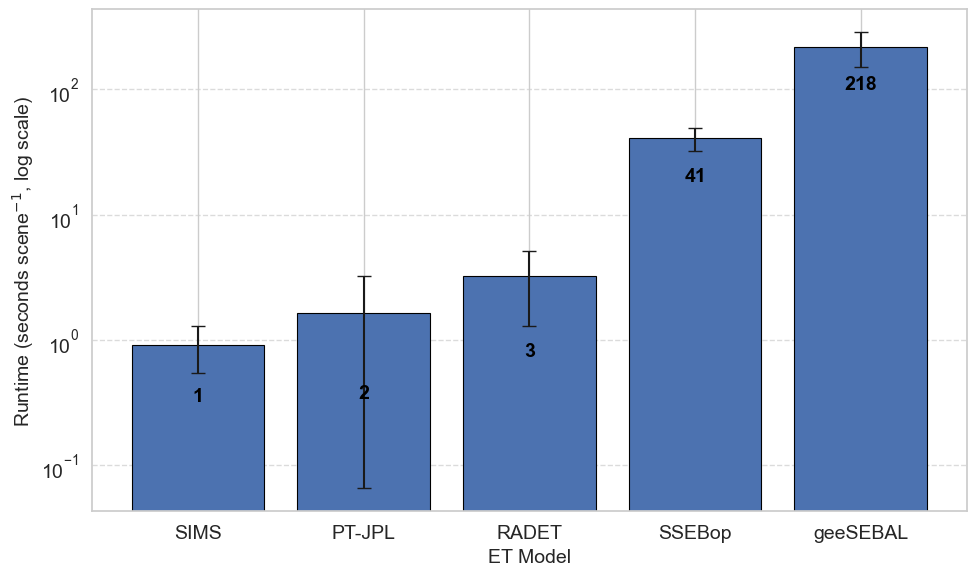

In [29]:
sns.set_theme(style='whitegrid', font_scale=1.2)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    summary_5k.index,
    summary_5k['Mean (s)'],
    yerr=summary_5k['Std (s)'],
    capsize=5,
    edgecolor='black',
    linewidth=0.8,
)
offset_vals = [-0.1, -0.45, -0.8, 0, 0] # Adjust as needed for each bar
# Annotate bars with mean runtime (inside bars)
for bar, mean_val in zip(bars, summary_5k['Mean (s)']):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2 + offset_vals[bars.index(bar)],
        f'{int(round(mean_val))}',
        ha='center', va='center', fontweight='bold', color='black', fontsize=14,
    )

ax.set_yscale('log')
ax.set_xlabel('ET Model', fontsize=14)
ax.set_ylabel('Runtime (seconds scene$^{-1}$, log scale)', fontsize=14)
# ax.set_title('OpenET Single Image ET Runtime Comparison\n'
#              f'(Landsat 8, {len(SCENE_IDS)} scenes, 5 km buffer)', fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()
fig.savefig(OUTPUT_DIR / 'runtime_comparison_buffer.png', dpi=600, bbox_inches='tight')
plt.show()

### Per-Trial Runtime Distribution [5k buffer]

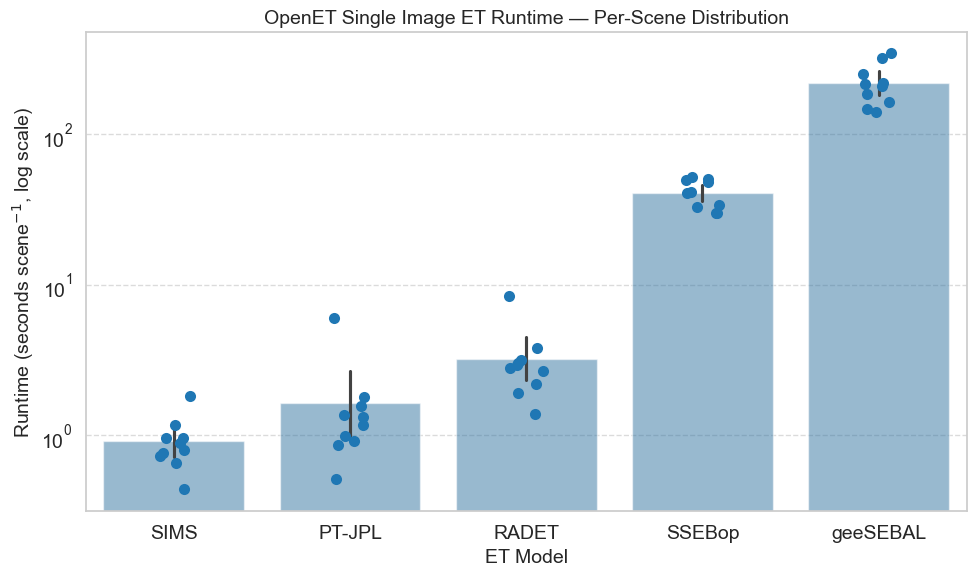

In [22]:
# Order models by mean runtime
model_order_5k = summary_5k.index.tolist()

fig, ax = plt.subplots(figsize=(10, 6))
sns.stripplot(
    data=df_5k, x='Model', y='Runtime (s)',
    order=model_order_5k,
    color=sns.color_palette("tab10")[0], size=8, jitter=True, ax=ax, legend=False,
)
sns.barplot(
    data=df_5k, x='Model', y='Runtime (s)',
    order=model_order_5k,
    color=sns.color_palette("tab10")[0], alpha=0.5, ax=ax, legend=False,
)
ax.set_yscale('log')
ax.set_xlabel('ET Model', fontsize=14)
ax.set_ylabel('Runtime (seconds scene$^{-1}$, log scale)', fontsize=14)
ax.set_title('OpenET Single Image ET Runtime — Per-Scene Distribution', fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()
plt.show()

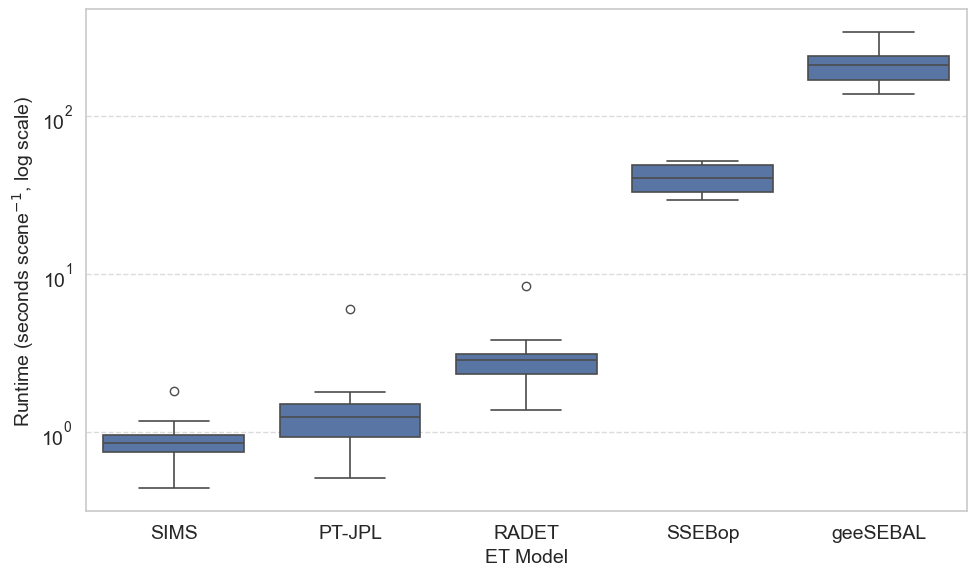

In [23]:
# Boxplot of runtime distribution [5k buffer]
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=df_5k, x='Model', y='Runtime (s)',
    order=model_order_5k,
    linewidth=1.2, ax=ax,
)
ax.set_yscale('log')
ax.set_xlabel('ET Model', fontsize=14)
ax.set_ylabel('Runtime (seconds scene$^{-1}$, log scale)', fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()
fig.savefig(OUTPUT_DIR / 'runtime_boxplot_buffer.png', dpi=600, bbox_inches='tight')
plt.show()

## Compare RADET with OpenET PT-JPL, SIMS, and SSEBop for full Landsat scenes

In [37]:
# 10 different Landsat 8 scenes for full-scene benchmarks (no buffer)
FULL_SCENE_IDS = [
    'LANDSAT/LC08/C02/T1_L2/LC08_041027_20240815',  # ID, MT (Intermountain West)
    'LANDSAT/LC08/C02/T1_L2/LC08_033037_20240823',  # NM (Southwest)
    'LANDSAT/LC08/C02/T1_L2/LC08_030034_20240818',  # KS/OK (Central Plains)
    'LANDSAT/LC08/C02/T1_L2/LC08_027027_20240813',  # MN/WI (Upper Midwest)
    'LANDSAT/LC08/C02/T1_L2/LC08_017031_20240807',  # PA (Mid-Atlantic)
    'LANDSAT/LC08/C02/T1_L2/LC08_022033_20240826',  # KY/IL (Midwest)
    'LANDSAT/LC08/C02/T1_L2/LC08_038032_20240810',  # UT
    'LANDSAT/LC08/C02/T1_L2/LC08_029029_20240827',  # SD/MN (Northern Plains)
    'LANDSAT/LC08/C02/T1_L2/LC08_014032_20240818',  # NJ/PA (Northeast)
    'LANDSAT/LC08/C02/T1_L2/LC08_025039_20240815',  # TX/LA (Gulf Coast)
]

In [38]:
# Validate that all scenes exist in GEE
for sid in FULL_SCENE_IDS:
    try:
        info = ee.Image(sid).getInfo()
        status = 'OK' if info else 'NOT FOUND'
    except Exception as e:
        status = f'ERROR: {e}'
    print(f'{status:10s}  {sid.split("/")[-1]}')

OK          LC08_041027_20240815
OK          LC08_033037_20240823
OK          LC08_030034_20240818
OK          LC08_027027_20240813
OK          LC08_017031_20240807
OK          LC08_022033_20240826
OK          LC08_038032_20240810
OK          LC08_029029_20240827
OK          LC08_014032_20240818
OK          LC08_025039_20240815


In [39]:
def benchmark_model_full_scene(model_factory, scene_ids=FULL_SCENE_IDS, buffer=None):
    """Benchmark a model across multiple Landsat scenes.
    
    Parameters
    ----------
    model_factory : callable
        Function that takes an ee.Image and returns the ET ee.Image.
    scene_ids : list of str
        Landsat image IDs to benchmark.
    buffer: int
        Buffer around the image centroid
    
    Returns
    -------
    list of float
        Wallclock seconds for each scene.
    """
    times = []
    n = len(scene_ids)
    for i, sid in enumerate(scene_ids):
        img = ee.Image(sid)
        region = img.geometry()
        if buffer:
            region = region.centroid().buffer(5000) # 5 km buffer around centroid to avoid GEE memory issues
        et_image = model_factory(img)
        # Add a unique server-side random noise band to defeat GEE caching.
        # ee.Image.random() with a unique seed produces a distinct computation
        # graph each time, and multiplying by 1e-10 makes it negligible.
        noise = ee.Image.random(i * n + hash(sid)).multiply(1e-10)
        et_image = et_image.add(noise)
        start = time.time()
        et_image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=30,
            bestEffort=True,
        ).getInfo()
        elapsed = time.time() - start
        times.append(elapsed)
        scene_short = sid.split('/')[-1]
        print(f'  Scene {i + 1}/{n} ({scene_short}): {elapsed:.2f}s')
    return times

In [35]:
results = {}

# Common kwargs for models that need ET reference
et_ref_kwargs = dict(
    et_reference_source='IDAHO_EPSCOR/GRIDMET',
    et_reference_band='etr',
    et_reference_resample='bilinear',
)

### RADET

In [ ]:
print('Benchmarking RADET...')
def radet_factory(img):
    return radet.Image.from_landsat_c2_sr(
        img, meteorology_source_daily='IDAHO_EPSCOR/GRIDMET', **et_ref_kwargs,
    ).et
results['RADET'] = benchmark_model_full_scene(radet_factory)

Benchmarking RADET...
  Scene 1/10 (LC08_041027_20240815): 29.97s
  Scene 2/10 (LC08_033037_20240823): 26.12s
  Scene 3/10 (LC08_030034_20240818): 28.53s
  Scene 4/10 (LC08_027027_20240813): 26.20s
  Scene 5/10 (LC08_017031_20240807): 20.06s
  Scene 6/10 (LC08_022033_20240826): 34.68s
  Scene 7/10 (LC08_038032_20240810): 26.83s
  Scene 8/10 (LC08_029029_20240827): 29.15s
  Scene 9/10 (LC08_014032_20240818): 14.30s
  Scene 10/10 (LC08_025039_20240815): 23.57s


### PT-JPL

In [ ]:
print('Benchmarking PT-JPL...')
def ptjpl_factory(img):
    return openet.ptjpl.Image.from_landsat_c2_sr(img).et
results['PT-JPL'] = benchmark_model_full_scene(ptjpl_factory)

Benchmarking PT-JPL...
  Scene 1/10 (LC08_041027_20240815): 13.19s
  Scene 2/10 (LC08_033037_20240823): 19.04s
  Scene 3/10 (LC08_030034_20240818): 16.01s
  Scene 4/10 (LC08_027027_20240813): 24.61s
  Scene 5/10 (LC08_017031_20240807): 14.11s
  Scene 6/10 (LC08_022033_20240826): 17.35s
  Scene 7/10 (LC08_038032_20240810): 45.22s
  Scene 8/10 (LC08_029029_20240827): 12.13s
  Scene 9/10 (LC08_014032_20240818): 8.50s
  Scene 10/10 (LC08_025039_20240815): 37.27s


### SIMS

In [ ]:
print('Benchmarking SIMS...')
def sims_factory(img):
    return openet.sims.Image.from_landsat_c2_sr(img, **et_ref_kwargs).et
results['SIMS'] = benchmark_model_full_scene(sims_factory)

Benchmarking SIMS...
  Scene 1/10 (LC08_041027_20240815): 7.30s
  Scene 2/10 (LC08_033037_20240823): 6.14s
  Scene 3/10 (LC08_030034_20240818): 6.01s
  Scene 4/10 (LC08_027027_20240813): 8.67s
  Scene 5/10 (LC08_017031_20240807): 3.78s
  Scene 6/10 (LC08_022033_20240826): 7.36s
  Scene 7/10 (LC08_038032_20240810): 6.26s
  Scene 8/10 (LC08_029029_20240827): 5.21s
  Scene 9/10 (LC08_014032_20240818): 5.82s
  Scene 10/10 (LC08_025039_20240815): 6.25s


### SSEBop

In [133]:
print('Benchmarking SSEBop...')
def ssebop_factory(img):
    return openet.ssebop.Image.from_landsat_c2_sr(img, **et_ref_kwargs).et
results['SSEBop'] = benchmark_model_full_scene(ssebop_factory, scene_ids=FULL_SCENE_IDS)

Benchmarking SSEBop...
  Scene 1/10 (LC08_041027_20240815): 131.74s
  Scene 2/10 (LC08_033037_20240823): 111.82s
  Scene 3/10 (LC08_030034_20240818): 111.50s
  Scene 4/10 (LC08_027027_20240813): 107.60s
  Scene 5/10 (LC08_017031_20240807): 84.68s
  Scene 6/10 (LC08_022033_20240826): 101.77s
  Scene 7/10 (LC08_038032_20240810): 90.43s
  Scene 8/10 (LC08_029029_20240827): 90.68s
  Scene 9/10 (LC08_014032_20240818): 106.84s
  Scene 10/10 (LC08_025039_20240815): 93.06s


### geeSEBAL

In [ ]:
print('Benchmarking geeSEBAL...')
def geesebal_factory(img):
    return openet.geesebal.Image.from_landsat_c2_sr(img).et
results['geeSEBAL'] = benchmark_model_full_scene(geesebal_factory, buffer=5000)

Benchmarking geeSEBAL...
  Scene 1/10 (LC08_041027_20240815): 147.86s
  Scene 2/10 (LC08_033037_20240823): 141.43s
  Scene 3/10 (LC08_030034_20240818): 129.32s
  Scene 4/10 (LC08_027027_20240813): 179.12s
  Scene 5/10 (LC08_017031_20240807): 80.62s
  Scene 6/10 (LC08_022033_20240826): 213.10s
  Scene 7/10 (LC08_038032_20240810): 140.53s
  Scene 8/10 (LC08_029029_20240827): 174.73s
  Scene 9/10 (LC08_014032_20240818): 127.18s
  Scene 10/10 (LC08_025039_20240815): 117.19s


### Results

In [30]:
load_existing = True # If False, results must have values from the model runs.

In [31]:
if load_existing:
    df = pd.read_csv(OUTPUT_DIR / 'runtime_analysis_full.csv')
else:
    # Build results DataFrame
    rows = []
    for model_name, times in results.items():
        for t in times:
            rows.append({'Model': model_name, 'Runtime (s)': t})
    df = pd.DataFrame(rows)
    df['Landsat Scene'] = FULL_SCENE_IDS * df.Model.nunique()
    df['Full Scene'] = True
    df.loc[df.Model == 'geeSEBAL', 'Full Scene'] = False
    df.to_csv(OUTPUT_DIR / 'runtime_analysis_full.csv', index=False)

# Summary statistics
summary = df.groupby('Model')['Runtime (s)'].agg(['mean', 'std', 'min', 'max'])
summary = summary.sort_values('mean')
summary.columns = ['Mean (s)', 'Std (s)', 'Min (s)', 'Max (s)']
print(summary.to_string())

            Mean (s)    Std (s)    Min (s)     Max (s)
Model                                                 
SIMS        6.281657   1.318290   3.777226    8.674856
PT-JPL     20.741658  11.781411   8.495612   45.218964
RADET      25.940062   5.639886  14.295899   34.679454
SSEBop    103.012609  13.975101  84.678970  131.744146
geeSEBAL  145.106604  36.831368  80.616906  213.101423


### Results Comparison Chart

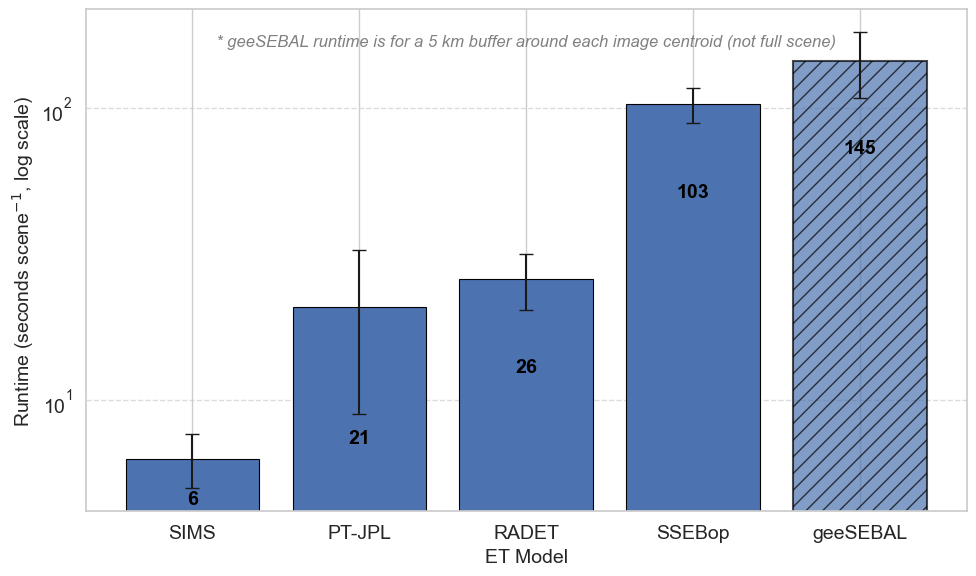

In [32]:
sns.set_theme(style='whitegrid', font_scale=1.2)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    summary.index,
    summary['Mean (s)'],
    yerr=summary['Std (s)'],
    capsize=5,
    edgecolor='black',
    linewidth=0.8,
)

# Highlight geeSEBAL bar with hatching to indicate 5 km buffer
for bar, model_name in zip(bars, summary.index):
    if model_name == 'geeSEBAL':
        bar.set_hatch('//')
        bar.set_edgecolor('black')
        bar.set_linewidth(1.5)
        bar.set_alpha(0.7)

offset_vals = [1.42, -3, 0, 0, 0] # Adjust as needed for each bar
# Annotate bars with mean runtime (inside bars)
for bar, mean_val in zip(bars, summary['Mean (s)']):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2 + offset_vals[bars.index(bar)],
        f'{int(round(mean_val))}',
        ha='center', va='center', fontweight='bold', color='black', fontsize=14,
    )

ax.set_yscale('log')
ax.set_xlabel('ET Model', fontsize=14)
ax.set_ylabel('Runtime (seconds scene$^{-1}$, log scale)', fontsize=14)
# ax.set_title('OpenET Single Image ET Runtime Comparison\n'
#              f'(Landsat 8, {len(FULL_SCENE_IDS)} full scenes)', fontsize=14)

# Footnote about geeSEBAL
ax.annotate(
    '* geeSEBAL runtime is for a 5 km buffer around each image centroid (not full scene)',
    xy=(0.5, 0.95), xycoords='axes fraction',
    ha='center', va='top', fontsize=12, fontstyle='italic', color='grey',
)

ax.tick_params(axis='both', labelsize=14)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()
fig.savefig(OUTPUT_DIR / 'runtime_comparison_full_scene.png', dpi=600, bbox_inches='tight')
plt.show()

### Per-Trial Runtime Distribution

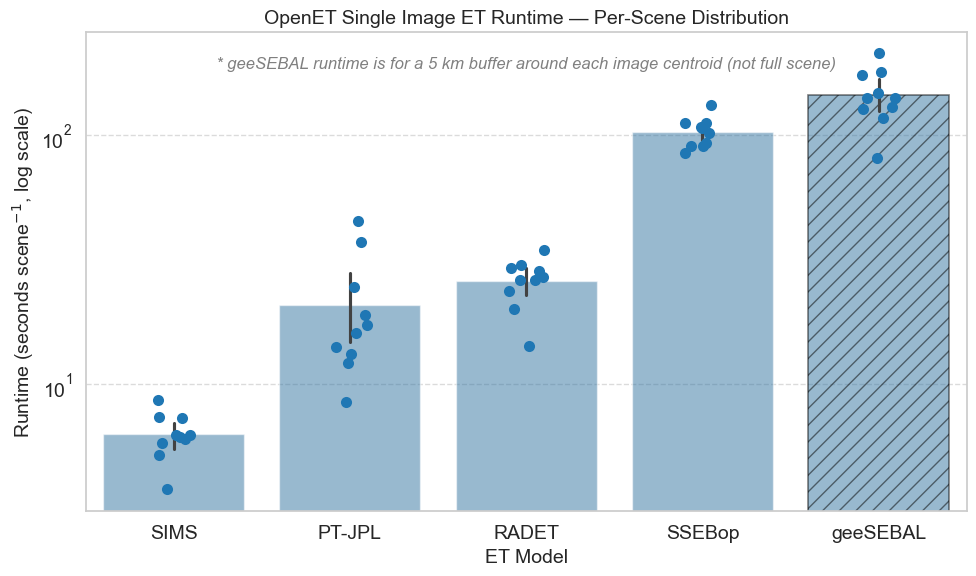

In [25]:
# Order models by mean runtime and build a consistent color map
model_order = summary.index.tolist()

fig, ax = plt.subplots(figsize=(10, 6))
sns.stripplot(
    data=df, x='Model', y='Runtime (s)',
    order=model_order,
    color=sns.color_palette("tab10")[0],
    size=8, jitter=True, ax=ax, legend=False,
)
sns.barplot(
    data=df, x='Model', y='Runtime (s)',
    order=model_order,
    color=sns.color_palette("tab10")[0],
    alpha=0.5, ax=ax, legend=False,
)

# Hatch geeSEBAL bar to indicate 5 km buffer
geesebal_idx = model_order.index('geeSEBAL') if 'geeSEBAL' in model_order else None
if geesebal_idx is not None:
    ax.patches[geesebal_idx].set_hatch('//')
    ax.patches[geesebal_idx].set_edgecolor('black')
    ax.patches[geesebal_idx].set_linewidth(1.2)

ax.set_yscale('log')
ax.set_xlabel('ET Model', fontsize=14)
ax.set_ylabel('Runtime (seconds scene$^{-1}$, log scale)', fontsize=14)
ax.set_title('OpenET Single Image ET Runtime — Per-Scene Distribution', fontsize=14)

# Footnote about geeSEBAL
ax.annotate(
    '* geeSEBAL runtime is for a 5 km buffer around each image centroid (not full scene)',
    xy=(0.5, 0.95), xycoords='axes fraction',
    ha='center', va='top', fontsize=12, fontstyle='italic', color='gray',
)

ax.tick_params(axis='both', labelsize=14)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()
plt.show()

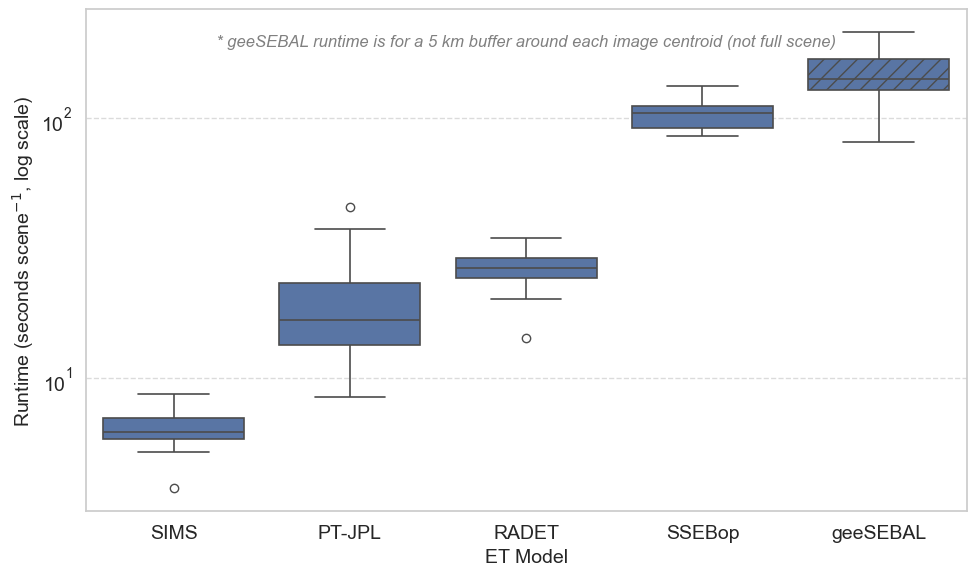

In [26]:
# Boxplot of runtime distribution [full scene]
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=df, x='Model', y='Runtime (s)',
    order=model_order,
    linewidth=1.2, ax=ax,
)

# Hatch geeSEBAL box to indicate 5 km buffer
geesebal_idx = model_order.index('geeSEBAL') if 'geeSEBAL' in model_order else None
if geesebal_idx is not None:
    for patch in ax.patches:
        if ax.patches.index(patch) == geesebal_idx:
            patch.set_hatch('//')

ax.set_yscale('log')
ax.set_xlabel('ET Model', fontsize=14)
ax.set_ylabel('Runtime (seconds scene$^{-1}$, log scale)', fontsize=14)

# Footnote about geeSEBAL
ax.annotate(
    '* geeSEBAL runtime is for a 5 km buffer around each image centroid (not full scene)',
    xy=(0.5, 0.95), xycoords='axes fraction',
    ha='center', va='top', fontsize=12, fontstyle='italic', color='gray',
)

ax.tick_params(axis='both', labelsize=14)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()
fig.savefig(OUTPUT_DIR / 'runtime_boxplot_full_scene.png', dpi=600, bbox_inches='tight')
plt.show()